# Preparación
Se monta el sistema de archivos de google drive.


In [48]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-01-08 19:14:23.905206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'/device:GPU:0'

2022-01-08 19:14:23.905957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:14:23.906379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:14:23.906980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:14:23.907367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 19:14:23.907669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 1

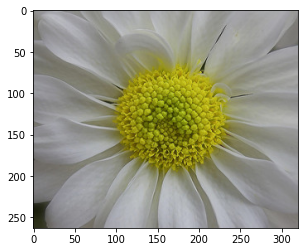

In [49]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [50]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# Modelo

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization

In [52]:
model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))

# Capa 1
model.add(Conv2D(96, kernel_size=(11, 11), strides = (4,4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2)))

# Capa 2
model.add(Conv2D(256, kernel_size=(5, 5), strides = (1,1), activation='relu', padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2)))

# Capa 3
model.add(Conv2D(384, kernel_size=(3, 3), strides = (1,1), activation='relu', padding = "same"))
model.add(BatchNormalization())

# Capa 4
model.add(Conv2D(384, kernel_size=(3, 3), strides = (1,1), activation='relu', padding = "same"))
model.add(BatchNormalization())

# Capa 5
model.add(Conv2D(256, kernel_size=(3, 3), strides = (1,1), activation='relu', padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2)))

# Capa 6
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Capa 7
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

#Capa 8
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Visualización del modelo

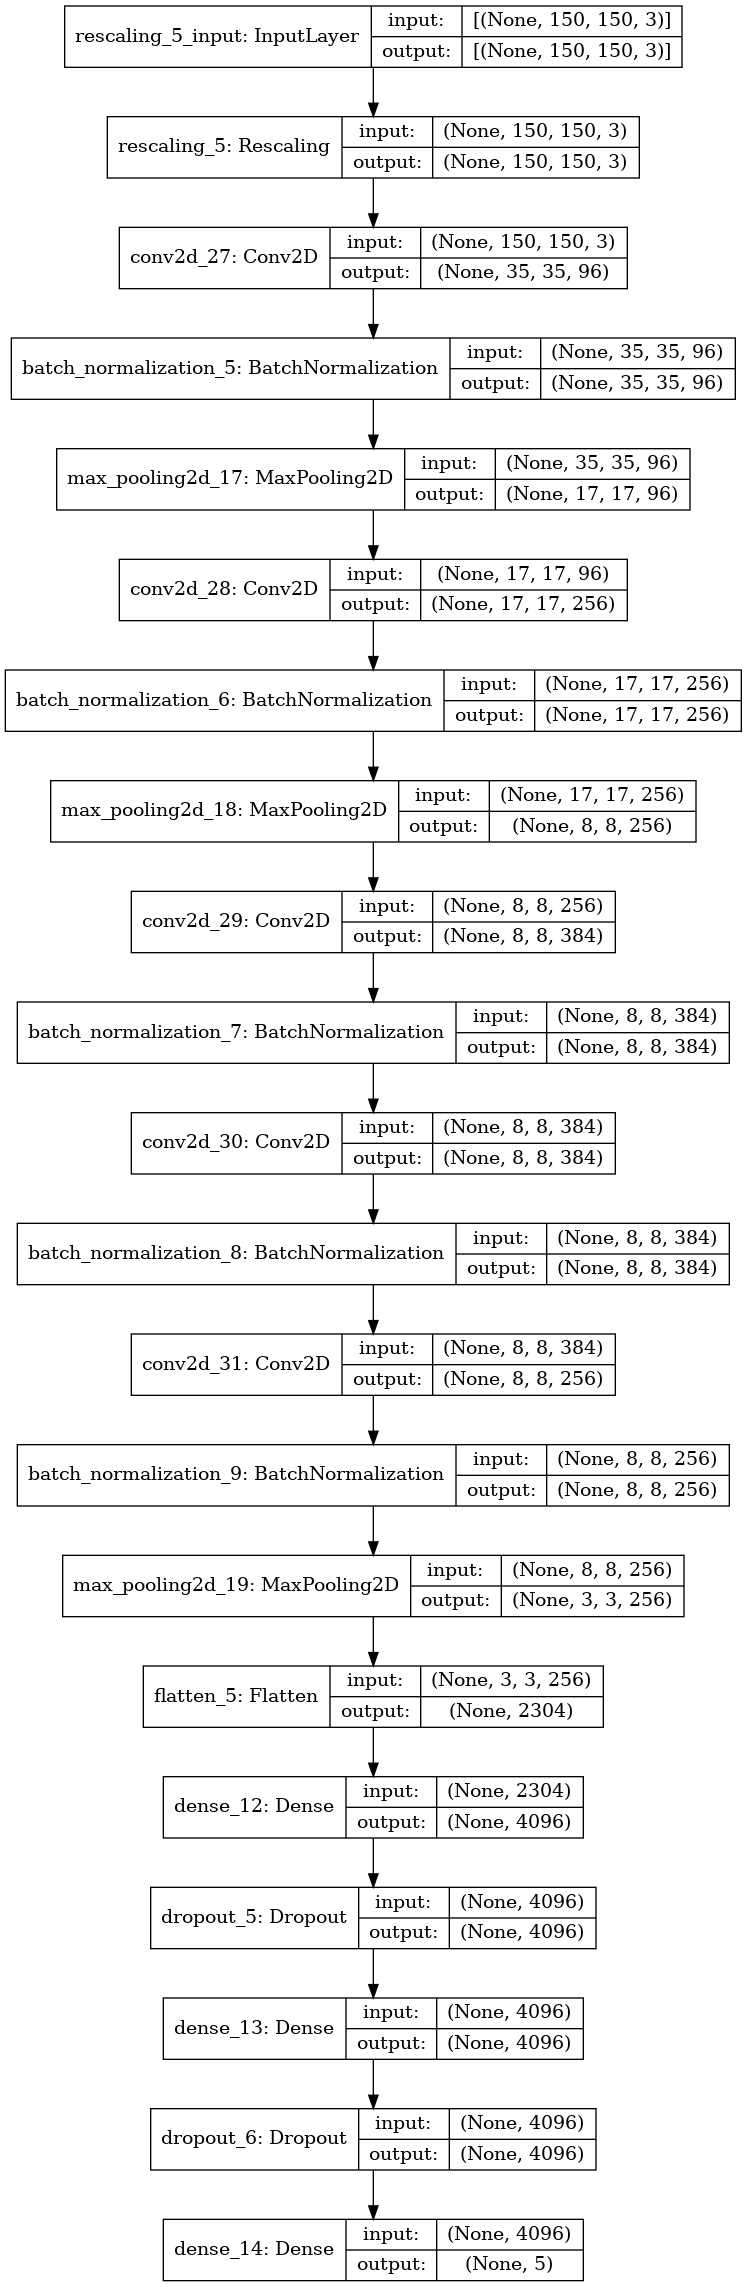

In [53]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [54]:
from keras.callbacks import EarlyStopping

epochs = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/150
108/108 [==============================] - 7s 57ms/step - loss: 2.7894 - accuracy: 0.2145 - val_loss: 1.6026 - val_accuracy: 0.2364
Epoch 2/150
108/108 [==============================] - 7s 60ms/step - loss: 2.4704 - accuracy: 0.2658 - val_loss: 1.6559 - val_accuracy: 0.2109
Epoch 3/150
108/108 [==============================] - 7s 58ms/step - loss: 2.2627 - accuracy: 0.3052 - val_loss: 1.6688 - val_accuracy: 0.3001
Epoch 4/150
108/108 [==============================] - 6s 57ms/step - loss: 2.1372 - accuracy: 0.3327 - val_loss: 1.5377 - val_accuracy: 0.3592
Epoch 5/150
108/108 [==============================] - 7s 58ms/step - loss: 2.0157 - accuracy: 0.3584 - val_loss: 1.3074 - val_accuracy: 0.4670
Epoch 6/150
108/108 [==============================] - 6s 56ms/step - loss: 1.9431 - accuracy: 0.3732 - val_loss: 1.2116 - val_accuracy: 0.5180
Epoch 7/150
108/108 [==============================] - 7s 58ms/step - loss: 1.8732 - accuracy: 0.3940 - val_loss: 1.1966 - val_accuracy:

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

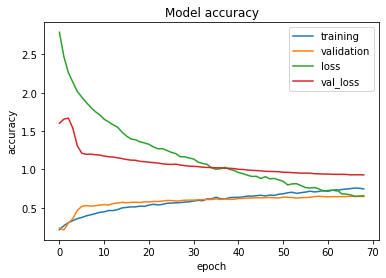

In [55]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss', 'val_loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.5912    0.5870    0.5891       138
           1     0.7094    0.6888    0.6989       241
           2     0.5099    0.6016    0.5520       128
           3     0.7800    0.7267    0.7524       161
           4     0.6283    0.6154    0.6218       195

    accuracy                         0.6501       863
   macro avg     0.6438    0.6439    0.6428       863
weighted avg     0.6558    0.6501    0.6521       863



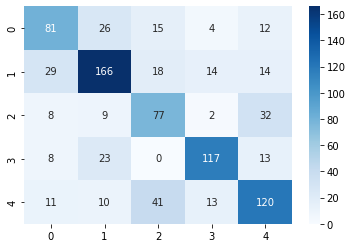

In [56]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [57]:
img = keras.preprocessing.image.load_img(
    '../input/flowers-recognition/flowers/daisy/10172636503_21bededa75_n.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1
